# Create Custom Dataset

The limitations of `torchvision.datasets.ImageFolder` API are as following reasons:
- Root directory should have only classes directories with images in its directories.
- It is only useful for the classification problem.
- Just using this API does not solve training and validation split.

## 1. Explore 10 Monkey Species dataset

We can download the dataset in Kaggle: [10 monkey species dataset](https://www.kaggle.com/slothkong/10-monkey-species/download).

**Extracted Folder structure:**

```
data_root
├── training
│   └── training
│       ├── n0
│       ├── n1
│       ├── n2
│       ├── n3
│       ├── n4
│       ├── n5
│       ├── n6
│       ├── n7
│       ├── n8
│       └── n9
└── validation
    └── validation
        ├── n0
        ├── n1
        ├── n2
        ├── n3
        ├── n4
        ├── n5
        ├── n6
        ├── n7
        ├── n8
        └── n9
```

`data_root/training/training` as well as `data_root/validation/validation` have `n0-n9` folders; 
each folder has images of corresponding class.

**Label mapping:** Root directory also has a folder-to-Species mapping file `monkey_labels.txt`.

|Label | Monkey Species |
| --- | --- |
| n0 | alouatta_palliata |
| n1 | erythrocebus_patas |
| n2 | cacajao_calvus |
| n3 | macaca_fuscata |
| n4 | cebuella_pygmea |
| n5 | cebus_capucinus |
| n6 | mico_argentatis |
| n7 | saimiri_sciureus |
| n8 | aotus_nigriceps |
| n9 | trachypithecus_johnii |

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import functional as F

## 2. Custom Dataset Class

`torch.utils.data.Dataset` is an abstract class representing a dataset.
When we write custom dataset, we have to override the following methods:
1. **\_\_len\_\_**: return the length of the dataset.
2. **\_\_getitem\_\_**: return $i^{th}$ sample.

In [2]:
class MonkeySpecies10Dataset(Dataset):
    def __init__(self, data_root, train=True, im_shape=None, transform=None):
        # Get label to species mapping
        label_cvs_path = os.path.join(data_root, 'monkey_labels.txt')
        self.label_df = pd.read_csv(label_cvs_path, delimiter=' *, *', engine='python')
        
        # set image_resize attribute
        if im_shape is None:
            self.im_shape = im_shape
        else:
            if isinstance(im_shape, int):
                self.im_shape = (im_shape, im_shape)
            elif isinstance(im_shape, tuple) or isinstance(im_shape, list):
                assert len(im_shape) == 1 or len(im_shape) == 2, 'Invalid image_shape tuple size'
                if len(im_shape) == 1:
                    self.im_shape = (im_shape[0], im_shape[0])
                else:
                    self.im_shape = im_shape
            else: 
                raise NotImplementedError
        
        # Set transform attribute
        self.transform = transform
        num_classes = 10
        
        # Initialize data dictionary
        self.data_dict = {
            'im_path': [],
            'label': []
        }
        
        # Set training/validation path
        if train:
            im_dir = os.path.join(data_root, 'training', 'training')
        else:
            im_dir = os.path.join(data_root, 'validation', 'validation')
        
        for i in range(num_classes):
            class_path = os.path.join(im_dir, 'n{}'.format(i))
            for im in os.listdir(class_path):
                if im.endswith('.jpg') or im.endswith('.png'):
                    im_path = os.path.join(class_path, im)
                    self.data_dict['im_path'].append(im_path)
                    self.data_dict['label'].append(i)
    
    def __len__(self):
        return len(self.data_dict['label'])
    
    def __getitem__(self, idx):
        im = Image.open(self.data_dict['im_path'][idx]).convert('RGB')
        if self.im_shape is not None:
            im = F.resize(im, self.im_shape)
        
        if self.transform is not None:
            im = self.transform(im)            
        target = self.data_dict['label'][idx]
        
        return im, target
    
    def common_name(self, label):
        return self.label_df['Common Name'][label]
    
    def latin_name(self, label):
        return self.label_df['Latin Name'][label]

Get an image sample from dataset.

In [3]:
data_root = './data/monkey_data/'
train_dataset = MonkeySpecies10Dataset(data_root=data_root, train=True, im_shape=256)
print('Length of the dataset: {}'.format(train_dataset.__len__()))

Length of the dataset: 1097


Label: 2, common name: bald_uakari, latin name: cacajao_calvus	


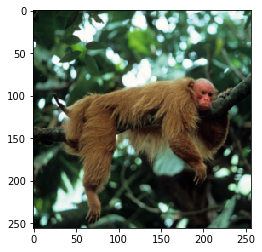

In [4]:
im, target = train_dataset[300]
print('Label: {}, common name: {}, latin name: {}'.format(target, 
                                                          train_dataset.common_name(target),
                                                          train_dataset.latin_name(target)))
plt.imshow(im)
plt.show()

## 3. Data Loader with Custom Dataset

In [5]:
preprocess_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(244),
    transforms.ToTensor()
])

test_dataset = MonkeySpecies10Dataset(data_root=data_root, 
                                      train=False, 
                                      im_shape=None,
                                      transform=preprocess_transforms)

Create DataLoader with dataset.

In [6]:
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=15,
                                          shuffle=True,
                                          num_workers=0)

Plot test images from data loader.

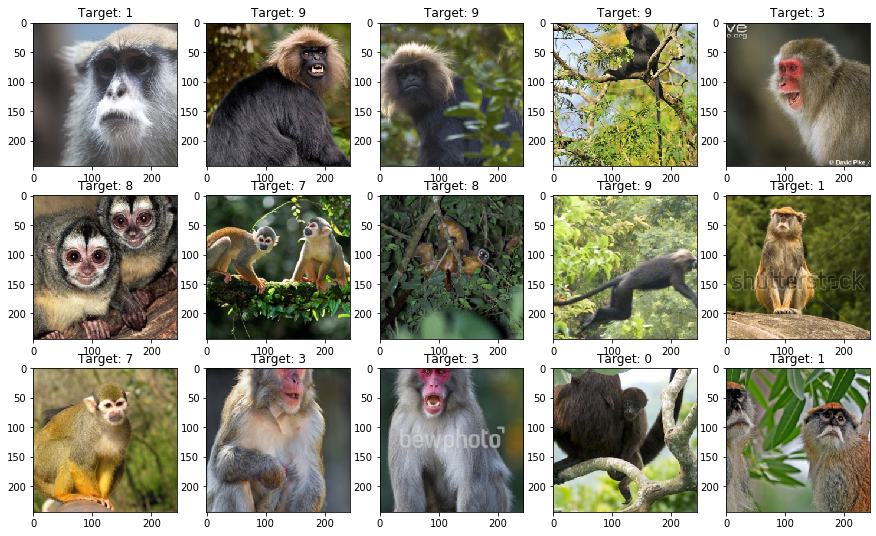

In [7]:
plt.rcParams['figure.figsize'] = (15, 9)

for (images, labels) in test_loader:
    for i in range(len(labels)):
        plt.subplot(3, 5, i + 1)
        im = F.to_pil_image(images[i])
        plt.imshow(im)
        plt.gca().set_title('Target: {}'.format(labels[i]))
    plt.show()
    break